Data Modeling
===

Author: Zachary Levonian

Date: April 2023

## Summary

The fundamental goal is to predict the targets based on patient and biomarker data.

No description is given of the data, so I make some reasonable assumptions based on column names.
My initial exploration of the data is contained in the `DataExploration` notebook (in this same directory); this notebook (`DataModeling`) contains the modeling and modeling results.
I wrote a Python package (`bcs`, an acronym for "biomarker case study") with code to assist with loading, processing, and modeling the data.
The classes and methods have docstrings that explain their purpose.

In the rest of this summary, I describe the choices I made in approaching this modeling problem.
I discuss: (a) the class of model, (b) the data and potential features, (c) evaluation metrics, and (d) model optimization. 
For each, I discuss possible extensions or alternatives that I didn't have time to explore here.
Because the modeling problem is very open-ended, I can summarize my high-level results here: 
the best model I produced had an ROC AUC score of 0.94 (accuracy 90%, F1 0.75), although performance varies by institution. 

### Model

What model should we use for this modeling problem?
We have an ambiguous classification problem with unclear intended use-cases.
Further, the data contains a large number of possible raw features, contains some missing data, and is structured.
This is an excellent fit for gradient boosting machines (GBMs).
The most prominent GBM implementations are LightGBM and XGBoost, but we'll just use the newer scikit-learn implementation (which is based on and benchmarks competitively with LightGBM).

#### Other options
Future work could explore other model classes, particularly if a particular use-case was identified for which a different model would be a better fit.

A few options worth considering:

 - Models like logistic regression have the benefit of familiarity to clinical audiences. Alternately, presenting the correlations or odds ratios for just a few of the patient variables could be useful for some audiences (at the cost of predictive power).
 - Alternative models could include other highly intepretable models. For example, an integer-only risk-scoring model (e.g. fit using [FasterRisk](https://github.com/jiachangliu/FasterRisk)) could be worth exploring.
 - Deep learning models could be used to learn separate embeddings for patients and biomarkers. These embeddings could be useful for more than just the given classification problem.
 - I don't consider model calibration at all, but for many applications it could be more important than raw predictive accuracy.

### Data and modeling features

Most of the feature visualization and development work is in the `DataExploration` notebook (in this same directory). To briefly summarize my findings in that notebook:

 - No patient or biomarker result is duplicated, i.e. we won't make multiple predictions for any patient.
 - The institution determines what data is available for each patient. For example, Montague Hospital is the only institution to collect BMI, alcohol usage, and exercise frequency.
 - Biomarkers follow reasonable distributions (see figures).
 - The data seem to contain a fairly typical US clinical population: median patient age is 61.
 - Some normalization and conversion is needed; this is accomplished in `bcs.data_loader`.
 
By using GBMs, we implicitly handle missing data as an additional level for categorical features or a presence indicator for continuous features.
I chose to use all available patient and biomarker features in the models I trained; we can trust that the GBM optimization will ignore irrelevant features. (For other model classes, I would be more concerned about colinearity.)
I did conduct experiments with using only patient-level or biomarker-level features. My results in this notebook indicate significantly greater performance using both sets of features (0.94 ROC AUC) compared to using only biomarker features (0.87 ROC AUC) or patient features (0.57 ROC AUC).

All categorical variables are treated as unordered, with the exception of disease sub-type.
Empirically, this decision did not affect performance (ROC AUC is the same in a patient-features-only model regardless of ordered vs unordered).

I conducted some brief experiments with dimensonality reduction, largely to demonstrate I was aware that this might be a reasonable technique to use when we have a large number of features (more than our total data size). However, GBMs are particularly excellent at parsing large numbers of boolean features, and 15K is honestly not that many features to begin with. But the approach would probably be necessary as we scale number of features to more than two orders of magnitude larger than our data (i.e. 100K+ features). Results from my experiments with Principal Component Analysis (PCA) demonstrate that using PCA reduces model performance substantially (0.61 ROC AUC with PCA vs 0.94 without). Using PCA does also reduce model training time.

#### Other options

There are many approaches I didn't have time to explicitly consider.

 - As mentioned above, we implicitly handle missing data using GBM. However, we might be able to do better by using domain knowledge or depending on our use-case. In particular, the fact that the Goodfellow Research Institute doesn't collect age or smoking status info may indicate other differences in data collection methodology that would need to be investigated. We assume that "days since diagnosis" is just a re-scaled form of "months since diagnosis", but the different available information may indicate other differences for which rescaling is insufficient. 
 - Some biomarkers are 0 or 1 almost all of the time. Removing them might increase convergence speed.
 - We don't explicitly model feature crosses. Interaction features are not very necessary in GBM models, but in other model classes (e.g. more explainable models) we might want explore including them. 

### Evaluation and metrics

This is a binary classification problem. 22% of the target outcomes are 1, which is a modest imbalance between classes. For this reason, accuracy alone would be a very misleading metric. Absent information about whether precision or recall are more important in this context, positive-class F1 and ROC AUC are both appropriate metrics. I primarily relied about ROC AUC to capture information about the relative ranking between predictions, absent any additional information about how the raw scores or predictions would be used.

Given our missing-data findings about differences between institutions, I chose to evaluate my models using grouped cross-validation on the patient's institution. 
In other words, I trained 7 models, each trained on patients from the other 6 institutions and used to make predictions on the held-out "validation" institution.
This approach fits well with extrapolating performance if this model was used to make predictions for a similar institution and data collection approach in the future. 
A downside to this cross-validation approach is that the validation folds have non-consistent sizes, making comparison between models challenging: the training set will be larger when predicting on patients at the smallest institutions. If it is critical to understand differential model performance by institution, we would need to conduct additional experiments while holding the training-data sample size fixed.

#### Other options

 - An additional downside to cross-validation is that it will produce overly optimistic estimates if used for hyperparameter tuning. We haven't done enough hyperparameter tuning on this dataset to be especially concerned, but if we were going to do a bunch of additional modeling development we would want to produce a held-out test set, likely from an institution for which we have no training data.
 - We have no temporal information in this data. Time information is likely to be important for proper evaluation and validation in the future. Related issues like domain shift can be investigated as temporal information becomes available.

### Model optimization and hyperparameter tuning

I trained all models on a single CPU core of a Macbook Air.
Therefore, I both didn't parellelize hyperparameter tuning (due to low available memory) and didn't train very many models during hyperparameter tuning.
As a result, I was selective about the experiments that I ran and the parameters I varied together.
Following [Google's tuning guidance](https://github.com/google-research/tuning_playbook#a-scientific-approach-to-improving-model-performance), I used iterative tuning within hand-designed parameter search spaces. 
In other words, I tuned in the following ways:
 - I set initial GBM hyperparameters based on patient-only models, because they fit much faster than models using the biomarker data.
 - I set final GBM hyperparameters based on models using all features, informed by the initial experiments.
 - I explored PCA, as described above.
 - I fit the final set of five models reported at the top of this notebook.

#### Other options

 - Use a proper AutoML library for hyperparameter optimization.
 - Parallelize hyperparameter optimization, to fit models more quickly.
 - Include model class as a "parameter", fitting multiple types of models and not just GBMs.
 
## Conclusion

The model I produced represents a reasonable first step. It achieves a reasonable ROC AUC score (0.94) for many potential applications, although many would require additional development.
The most critical follow-ups would involve grounding this analysis in a particular use-case: why are we trying to produce a model for this task? What kind of failure modes are most important?  What metrics and evaluation processes are most important for our use-case?


In [3]:
from pathlib import Path

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

import bcs.data_loader
import bcs.modeling

In [4]:
data_dir = (Path.cwd() / ".." / "data").resolve()
assert data_dir.exists()
figures_dir = (Path.cwd() / ".." / "figures").resolve()
figures_dir.mkdir(exist_ok=True)

In [5]:
dl = bcs.data_loader.DataLoader(data_dir)

In [6]:
pdf = dl.get_patient_dataframe()
bdf = dl.get_biomarker_dataframe()
tdf = dl.get_target_dataframe()

Before we can model, we have to merge the data into a single dataframe.

In [7]:
mdf = pd.merge(tdf, pdf, how="left", left_on="patient_id", right_index=True)
mdf = pd.merge(mdf, bdf, how="left", left_on="biomarker_id", right_index=True)
mdf.shape

(1734, 15174)

## What model is best?

In [9]:
model_map = {}

In [10]:
configs = []
named_models = [
    {
        "experiment_name": "all",
    },
    {
        "experiment_name": "patient_only",
        "biomarker_feature_action": "exclude",
    },
    {
        "experiment_name": "patient_only_unorderedDisease",
        "biomarker_feature_action": "exclude",
        "is_disease_sub_type_ordered": False,
    },
    {
        "experiment_name": "biomarker_only",
        "patient_feature_action": "exclude",
    },
    {
        "experiment_name": "biomarker_only_svd",
        "patient_feature_action": "exclude",
        "biomarker_feature_action": "svd",
        "biomarker_svd_n_components": 10,
    },
]
for named_model in named_models:
    config = bcs.modeling.ModelingConfig(
        gbm_learning_rate=0.2,
        gbm_max_iter=200,
        gbm_max_leaf_nodes=31,
        gbm_min_samples_leaf=10,
        gbm_l2_regularization=0.01,
        **named_model,
    )
    configs.append(config)
assert len(configs) == len({c.experiment_name for c in configs}), "Experiment names not unique."
len(configs)

5

In [11]:
# fit any models we haven't fit yet
for config in tqdm(configs):
    if config.experiment_name in model_map:
        continue
    else:
        model_evaluator = bcs.modeling.ModelEvaluator(config, mdf)
        model = model_evaluator.train_and_evaluate()
        model_map[config.experiment_name] = model
len(model_map)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [24:34<00:00, 294.99s/it]


5

In [12]:
metrics_list = []
for model in model_map.values():
    metrics_list.extend(model.metrics_)
metrics = pd.DataFrame(metrics_list)

In [13]:
metrics.loc[metrics.institution_name == "All", ["experiment_name", "acc", "f1_pos", "roc_auc"]].sort_values(
    by="roc_auc", ascending=False
)

,experiment_name,acc,f1_pos,roc_auc
6,all,0.903691,0.748115,0.939739
27,biomarker_only,0.884083,0.664441,0.865614
13,patient_only,0.715110,0.262687,0.568481
20,patient_only_unorderedDisease,0.715110,0.262687,0.568481
34,biomarker_only_svd,0.750865,0.096234,0.510372


## Looking closer at the best model

In [24]:
m = metrics[(metrics.experiment_name == "all") & (metrics.institution_name != "All")]
m.sort_values(by="roc_auc", ascending=False)

,experiment_name,institution_name,n,n_pos,n_pos_pred,acc,f1_pos,roc_auc
2,all,Johnson & Bloom Hospitals,56,10,5,0.910714,0.666667,0.956522
3,all,Montague Hospital,330,78,64,0.921212,0.816901,0.951720
4,all,Saint Penelope Medical Center,231,48,36,0.913420,0.761905,0.946380
0,all,"BioLab, Inc.",696,155,106,0.895115,0.720307,0.938131
1,all,Goodfellow Research Institute,123,34,28,0.886179,0.774194,0.930601
5,all,University Hospital System,298,56,43,0.902685,0.707071,0.927022


In [26]:
m[["acc", "f1_pos", "roc_auc"]].mean().rename("Mean performance by institution").to_frame()

,Mean performance by institution
acc,0.904887
f1_pos,0.741174
roc_auc,0.941729


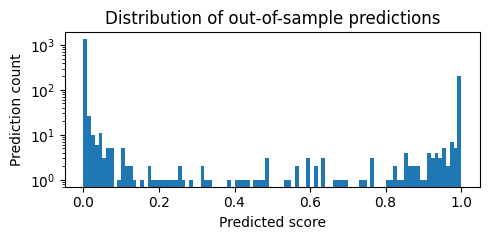

In [22]:
model = model_map["all"]
fig, ax = plt.subplots(1, 1, figsize=(5, 2.5))

bins = np.arange(0, 1.01, 0.01)
ax.hist(model.scores_, bins=bins, log=True)

ax.set_title("Distribution of out-of-sample predictions")
ax.set_xlabel("Predicted score")
ax.set_ylabel("Prediction count")

fig.tight_layout()
plt.show()

## Hyperparameter tuning

These experiments take a while to run (as the tqdm output below suggests), so they are maintained here as a record but not intended to be executed in normal cell execution flow. They were used to set the values used in the configurations above.

In [6]:
configs = []
for gbm_learning_rate in [0.1, 0.2]:
    for gbm_max_iter in [100, 200]:
        for gbm_max_leaf_nodes in [31, 63]:
            for gbm_min_samples_leaf in [10, 20]:
                for gbm_l2_regularization in [0.0, 0.02]:
                    config = bcs.modeling.ModelingConfig(
                        experiment_name=f"gbm_lr{gbm_learning_rate:.1f}_it{gbm_max_iter}_max{gbm_max_leaf_nodes}_min{gbm_min_samples_leaf}_r{gbm_l2_regularization:.2f}",
                        gbm_learning_rate=gbm_learning_rate,
                        gbm_max_iter=gbm_max_iter,
                        gbm_max_leaf_nodes=gbm_max_leaf_nodes,
                        gbm_min_samples_leaf=gbm_min_samples_leaf,
                        gbm_l2_regularization=gbm_l2_regularization,
                        biomarker_feature_action="exclude",
                    )
                    configs.append(config)
assert len(configs) == len({c.experiment_name for c in configs}), "Experiment names not unique."
len(configs)

32

In [12]:
configs = []
for gbm_learning_rate in [0.1, 0.2]:
    for gbm_max_iter in [100, 200]:
        for gbm_max_leaf_nodes in [31, 63]:
            for gbm_min_samples_leaf in [10, 20]:
                config = bcs.modeling.ModelingConfig(
                    experiment_name=f"gbm_lr{gbm_learning_rate:.1f}_it{gbm_max_iter}_max{gbm_max_leaf_nodes}_min{gbm_min_samples_leaf}",
                    gbm_learning_rate=gbm_learning_rate,
                    gbm_max_iter=gbm_max_iter,
                    gbm_max_leaf_nodes=gbm_max_leaf_nodes,
                    gbm_min_samples_leaf=gbm_min_samples_leaf,
                    gbm_l2_regularization=0.01,
                    biomarker_feature_action="keep",
                )
                configs.append(config)
assert len(configs) == len({c.experiment_name for c in configs}), "Experiment names not unique."
len(configs)

16

In [16]:
metrics_list = []
for config in tqdm(configs):
    model_evaluator = bcs.modeling.ModelEvaluator(config, mdf)
    model_metrics_list = model_evaluator.train_and_evaluate()
    metrics_list.extend(model_metrics_list)
len(metrics_list)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [3:05:01<00:00, 693.84s/it]


112

In [11]:
# hyperparameter tuning when biomarker features are excluded
# no longer captured in cell order
metrics = pd.DataFrame(metrics_list)
metrics.loc[metrics.institution_name == "All", ["experiment_name", "acc", "f1_pos", "roc_auc"]].sort_values(
    by="roc_auc", ascending=False
)

,experiment_name,acc,f1_pos,roc_auc
27,gbm_lr0.1_it100_max31_min20_r0.02,0.751442,0.273187,0.606639
20,gbm_lr0.1_it100_max31_min20_r0.00,0.737601,0.242928,0.605682
48,gbm_lr0.1_it100_max63_min20_r0.00,0.742215,0.258706,0.603535
13,gbm_lr0.1_it100_max31_min10_r0.02,0.751442,0.282862,0.601420
6,gbm_lr0.1_it100_max31_min10_r0.00,0.747982,0.255537,0.598858
76,gbm_lr0.1_it200_max31_min20_r0.00,0.728950,0.246795,0.594175
104,gbm_lr0.1_it200_max63_min20_r0.00,0.725490,0.253918,0.592889
55,gbm_lr0.1_it100_max63_min20_r0.02,0.737024,0.242525,0.592759
83,gbm_lr0.1_it200_max31_min20_r0.02,0.732987,0.263911,0.590530
69,gbm_lr0.1_it200_max31_min10_r0.02,0.738178,0.295031,0.589123


In [17]:
# hyperparameter tuning when biomarker features are included raw
# no longer captured in cell order
metrics = pd.DataFrame(metrics_list)
metrics.loc[metrics.institution_name == "All", ["experiment_name", "acc", "f1_pos", "roc_auc"]].sort_values(
    by="roc_auc", ascending=False
)

,experiment_name,acc,f1_pos,roc_auc
90,gbm_lr0.2_it200_max31_min10,0.906574,0.758209,0.943299
62,gbm_lr0.2_it100_max31_min10,0.907728,0.761905,0.942696
34,gbm_lr0.1_it200_max31_min10,0.907728,0.759036,0.941163
104,gbm_lr0.2_it200_max63_min10,0.906574,0.756757,0.940678
6,gbm_lr0.1_it100_max31_min10,0.908881,0.764881,0.940313
48,gbm_lr0.1_it200_max63_min10,0.905998,0.757079,0.939671
76,gbm_lr0.2_it100_max63_min10,0.908304,0.761619,0.939545
41,gbm_lr0.1_it200_max31_min20,0.904844,0.751131,0.938255
20,gbm_lr0.1_it100_max63_min10,0.908881,0.767647,0.937464
111,gbm_lr0.2_it200_max63_min20,0.904268,0.747720,0.937444


In [7]:
configs = []
for biomarker_svd_n_components in [None, 10, 50, 100, 1000]:
    config = bcs.modeling.ModelingConfig(
        experiment_name=f"gbm_svd{biomarker_svd_n_components}",
        gbm_learning_rate=0.2,
        gbm_max_iter=200,
        gbm_max_leaf_nodes=31,
        gbm_min_samples_leaf=10,
        gbm_l2_regularization=0.01,
        biomarker_feature_action="svd",
        biomarker_svd_n_components=biomarker_svd_n_components,
    )
    configs.append(config)
assert len(configs) == len({c.experiment_name for c in configs}), "Experiment names not unique."
len(configs)

6

In [ ]:
model_list = []
for config in tqdm(configs, desc="SVD experiments"):
    model_evaluator = bcs.modeling.ModelEvaluator(config, mdf)
    model = model_evaluator.train_and_evaluate()
    model_list.append(model)
len(model_list)

In [9]:
# hyperparameter tuning with SVD
# no longer captured in cell order
metrics_list = []
for model in model_list:
    metrics_list.extend(model.metrics_)
metrics = pd.DataFrame(metrics_list)
metrics.loc[metrics.institution_name == "All", ["experiment_name", "acc", "f1_pos", "roc_auc"]].sort_values(
    by="roc_auc", ascending=False
)

,experiment_name,acc,f1_pos,roc_auc
27,gbm_svd100,0.764706,0.209302,0.613485
20,gbm_svd50,0.777970,0.067797,0.610542
13,gbm_svd10,0.764706,0.227273,0.597756
34,gbm_svd1000,0.779700,0.010363,0.593636
6,gbm_svdNone,0.777970,0.005168,0.592006
